# LINK:https://www.kaggle.com/pranavraikokte/covid19-image-dataset

## Import Libraries

In [50]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL 
import tensorflow as tf
#import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import os
import plotly.express as px
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score,confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Dense, Flatten,BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
#from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from glob import glob
from tensorflow.keras.applications import DenseNet201 
from tensorflow.keras.layers import Dropout, Activation, Flatten, Convolution2D, MaxPooling2D,MaxPool2D,Conv2D
import imageio

import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image

## Importing and analysing Data

In [51]:
prec=[]             # to store all precisions of the applied classifiers
rcl=[]              # to store all recalls of the applied classifiers
f1=[]               # to store all f1-score of the applied classifiers
acc=[]              # to store all accuracies of the applied classifiers
rawlink="D:/Covid19-dataset/"
train_path=rawlink+"train"
test_path=rawlink+"test"
train_dir = pathlib.Path(train_path)
test_dir = pathlib.Path(test_path)
labels=os.listdir(test_dir)
print("Labels in the Data:",*labels, sep=", ")

Labels in the Data:, Covid, Normal, Viral Pneumonia


### Image Data Splitting

In [52]:
train_count = len(list(train_dir.glob('*/*.*')))
test_count = len(list(test_dir.glob('*/*.*')))

print(" ======================================")
print("  Images in Training set : {} \n  Images in Test det : {}".format(train_count,test_count))
print(" ======================================")
cats=["Train","Test"]
vals=[train_count, test_count]
valdf=pd.DataFrame({"Directories":cats,"Count":vals})
fig=px.pie(valdf,names="Directories",values="Count",color="Directories",
           title="Images in Train and Test Directories",height=600,width=600)
fig.update_traces(textposition='inside',textinfo='percent+label')
fig.update_layout(font=dict(family="Times New Roman, Bold",size=20,color="black"))
fig.show()

  Images in Training set : 251 
  Images in Test det : 66


In [53]:
trn=os.listdir(train_dir)
tst=os.listdir(test_dir)
trdata=[]
tsdata=[]
types=['Covid', 'Normal', 'Viral Pneumonia']
for i in trn:
    trdata.append(len(os.listdir(os.path.join(train_dir,i))))
for i in tst:
    tsdata.append(len(os.listdir(os.path.join(test_dir,i))))
xrayimages=pd.DataFrame({"Category":types,"Train":trdata,"Test":tsdata})
for i in range(len(xrayimages)):
    print("======================================================")
    print("  Available training images in {} is {}".format(xrayimages['Category'][i],xrayimages['Train'][i]))
    print("  Available test images in {} is {}".format(xrayimages['Category'][i],xrayimages['Test'][i]))
print("======================================================")

  Available training images in Covid is 111
  Available test images in Covid is 26
  Available training images in Normal is 70
  Available test images in Normal is 20
  Available training images in Viral Pneumonia is 70
  Available test images in Viral Pneumonia is 20


In [54]:
fig=px.pie(xrayimages,names="Category",values="Train",color="Category",title="Number of Images Train Set",height=600,width=600)
fig.update_traces(textposition='inside',textinfo='percent+label')
fig.update_layout(font=dict(family="Times New Roman, Bold",size=20,color="purple"))
fig.show()

In [55]:
fig=px.pie(xrayimages,names="Category",values="Test",color="Category",title="Number of Images Test Set",height=600,width=600)
fig.update_traces(textposition='inside',textinfo='percent+label')
fig.update_layout(font=dict(family="Times New Roman, Bold",size=20,color="purple"))
fig.show()

In [56]:
covid_train = list(train_dir.glob("Covid/*"))
pnemonia_train = list(train_dir.glob("Viral Pneumonia/*"))
normal_train = list(train_dir.glob("Normal/*"))

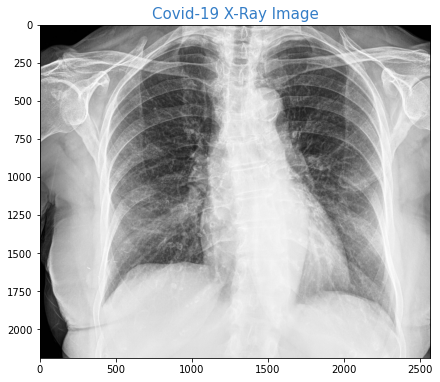

In [58]:
covid_img = PIL.Image.open(covid_train[18])        # using pillow library
plt.figure(figsize=(7,7))
plt.title("Covid-19 X-Ray Image",fontsize=15,color="#357EC7")
plt.imshow(covid_img)

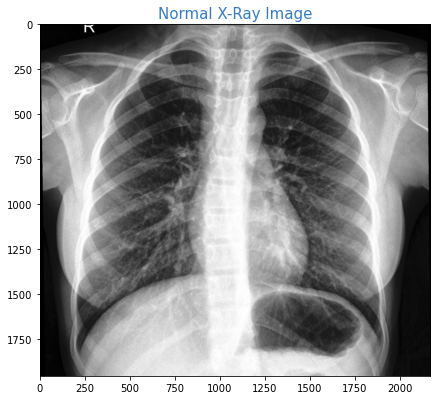

In [59]:
normal_img = PIL.Image.open(normal_train[10])
plt.figure(figsize=(7,7))
plt.title("Normal X-Ray Image",fontsize=15,color="#357EC7")
plt.imshow(normal_img)

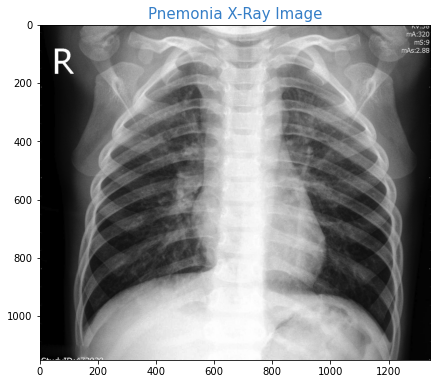

In [10]:
pnemonia_img = PIL.Image.open(pnemonia_train[12])
plt.figure(figsize=(7,7))
plt.title("Pnemonia X-Ray Image",fontsize=15,color="#357EC7")
plt.imshow(pnemonia_img)

## Load in tensorflow and preprocessing

In [60]:
# ImageDataGenerator is used to transform the image to image tensor array
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                     height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [61]:
batch_size = 16    
img_h = 300
img_w = 300

In [62]:
#here we are detecting the no of images belongs to training directory along with the number of classes
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  image_size=(img_h, img_w),
  batch_size=batch_size)
train_generator = train_datagen.flow_from_directory(
        train_path,
        classes=labels,
        target_size=(img_h, img_w),
        batch_size=32,
        class_mode='categorical')

Found 251 files belonging to 3 classes.
Found 251 images belonging to 3 classes.


In [63]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    image_size =(img_h,img_w),
    batch_size = batch_size)
test_generator = test_datagen.flow_from_directory(
        test_path,
        classes=labels,
        target_size=(img_h,img_w),
        batch_size=32,
        class_mode='categorical')

Found 66 files belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [64]:
class_names = train_ds.class_names
print(class_names)

['Covid', 'Normal', 'Viral Pneumonia']


## Visualizing the dataset

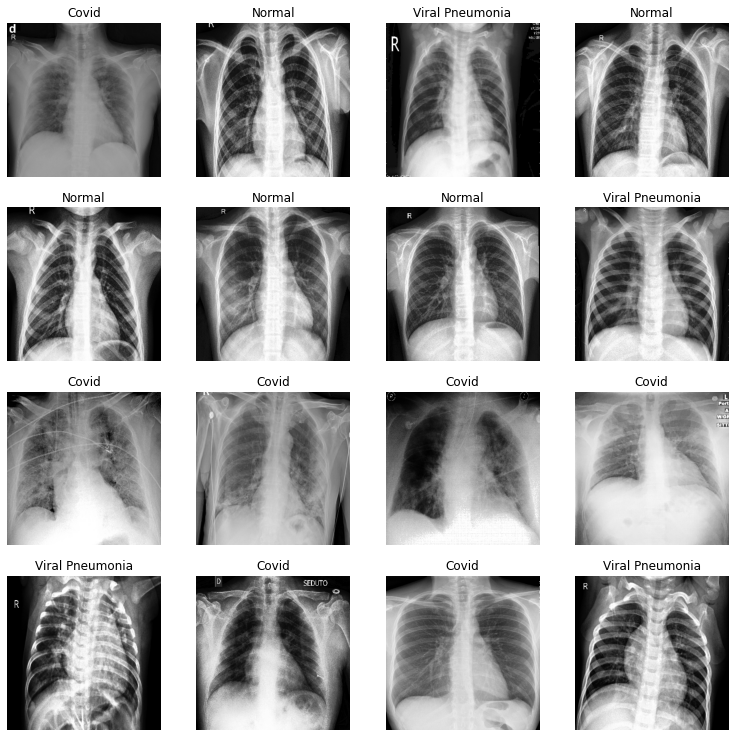

In [66]:
totplot=16
plt.figure(figsize=(13, 13))
for images, labels in train_ds.take(1):
    for i in range(totplot):
        ax = plt.subplot(int(totplot/4), int(totplot/4), i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [67]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 300, 300, 3)
(16,)


In [68]:
normalizing_layer = layers.experimental.preprocessing.Rescaling(1./255)

## Keras Sequencial Model for CNN

In [69]:
num_classes = 3

model_sq = Sequential([
    normalizing_layer,
    layers.Conv2D(16,3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation = "relu"),                # Relu-> rectified linear unit
    layers.Dense(num_classes),
    layers.Activation('softmax')
])                                  

In [70]:
# to avoid vanishing gradient Problem-> ADAM
model_sq.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])  

In [71]:
epochs=30
history_sq = model_sq.fit(
  train_generator,
  batch_size=16, 
  validation_data=test_generator,
  epochs=epochs)

Epoch 1/30
8/8 [==============================] - 60s 7s/step - loss: 1.0963 - accuracy: 0.4024 - val_loss: 1.0942 - val_accuracy: 0.3939
Epoch 2/30
8/8 [==============================] - 57s 7s/step - loss: 1.0794 - accuracy: 0.4422 - val_loss: 1.0984 - val_accuracy: 0.3939
Epoch 3/30
8/8 [==============================] - 52s 7s/step - loss: 1.0631 - accuracy: 0.4542 - val_loss: 1.0473 - val_accuracy: 0.5152
Epoch 4/30
8/8 [==============================] - 52s 7s/step - loss: 1.0548 - accuracy: 0.4422 - val_loss: 1.0222 - val_accuracy: 0.6212
Epoch 5/30
8/8 [==============================] - 57s 7s/step - loss: 1.0340 - accuracy: 0.5378 - val_loss: 0.9589 - val_accuracy: 0.5909
Epoch 6/30
8/8 [==============================] - 50s 6s/step - loss: 0.9289 - accuracy: 0.5697 - val_loss: 0.8535 - val_accuracy: 0.6212
Epoch 7/30
8/8 [==============================] - 49s 6s/step - loss: 0.8671 - accuracy: 0.6135 - val_loss: 0.7672 - val_accuracy: 0.6364
Epoch 8/30
8/8 [==================

In [23]:
model_sq.summary()    # MODEL SUMMARY

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, None, None, None)  0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 16)    448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 16)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
flatten_1 (Flatten)          (None, None)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [24]:
train_acc = history_sq.history['accuracy']
test_acc = history_sq.history['val_accuracy']
train_loss = history_sq.history['loss']
test_loss = history_sq.history['val_loss']
model_stat_sq=pd.DataFrame({
    "Epoch":[i+1 for i in range(30)],
    "Training Loss":train_loss,
    "Test Loss":test_loss,
    "Training Accuracy":train_acc,
    "Test Accuracy":test_acc
})
model_stat_sq.to_csv("model_sq.csv")
model_stat_sq

,Epoch,Training Loss,Test Loss,Training Accuracy,Test Accuracy
0,1,1.124594,1.091264,0.450199,0.393939
1,2,1.081807,1.095906,0.442231,0.393939
2,3,1.081011,1.092502,0.442231,0.393939
3,4,1.076132,1.084268,0.442231,0.393939
4,5,1.075133,1.088840,0.442231,0.393939
5,6,1.063218,1.065969,0.442231,0.393939
6,7,1.059798,1.045534,0.442231,0.393939
7,8,1.036540,1.023399,0.442231,0.393939
8,9,1.008470,0.972739,0.450199,0.545455
9,10,0.955524,0.929024,0.525896,0.636364


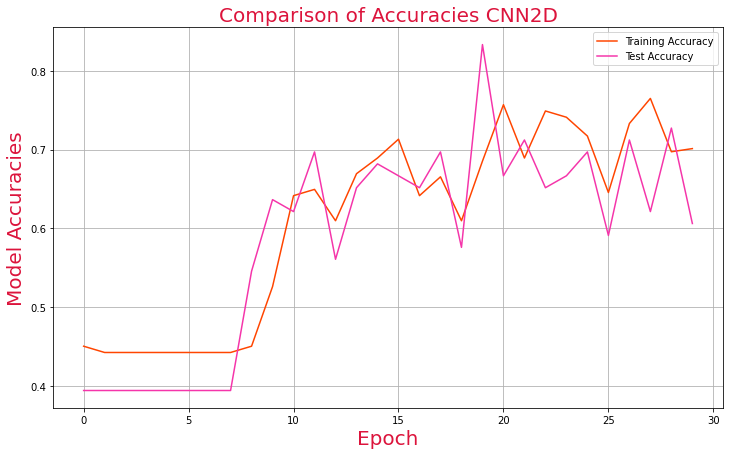

In [25]:
collist=["#FF4500","#F535AA"]
model_stat_sq.iloc[:,3:].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Accuracies CNN2D",fontsize=20,color="#DC143C")
plt.xlabel("Epoch",fontsize=20,color="#DC143C")
plt.ylabel("Model Accuracies",fontsize=20,color="#DC143C")
plt.grid()
plt.show()

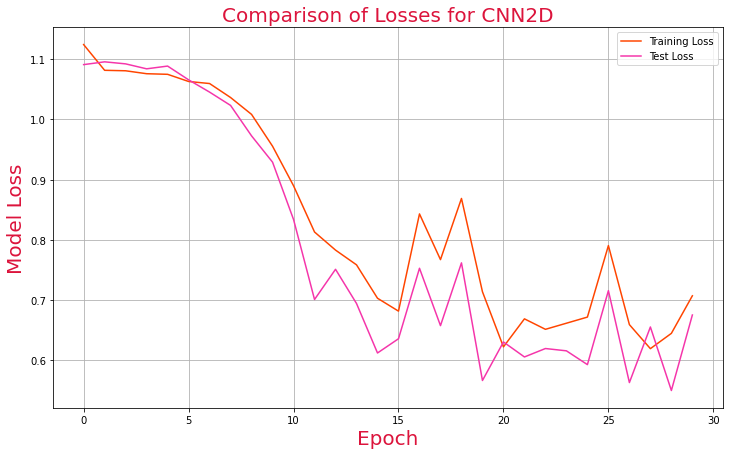

In [26]:
model_stat_sq.iloc[:,1:3].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Losses for CNN2D",fontsize=20,color="#DC143C")
plt.xlabel("Epoch",fontsize=20,color="#DC143C")
plt.ylabel("Model Loss",fontsize=20,color="#DC143C")
plt.grid()
plt.show()

In [27]:
y_pred = model_sq.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.classes
sq_out=pd.DataFrame({"Actual":class_labels,"Predicted":y_pred})     # dataframe for actual and predicted
sq_out["Actual"]=sq_out["Actual"].replace(sq_out["Actual"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
sq_out["Predicted"]=sq_out["Predicted"].replace(sq_out["Predicted"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
prec.append(round(precision_score(sq_out["Actual"], sq_out["Predicted"], average='micro'),2)*100)     # Precision of the model
rcl.append(round(recall_score(sq_out["Actual"], sq_out["Predicted"], average='micro'),2)*100)     # Recall of the model
f1.append(round(f1_score(sq_out["Actual"], sq_out["Predicted"], average='micro'),2)*100)     # F1-Score of the model
acc.append(round(model_stat_sq['Training Accuracy'].max(),4)*100)
print("Accuracy for CNN Model => {}%".format(round(model_stat_sq['Training Accuracy'].max(),4)*100))
ct_sq=pd.crosstab(sq_out["Actual"], sq_out["Predicted"], rownames=['True'], colnames=['Predicted'], margins=True)
ct_sq.iloc[:3,:3]

Accuracy for CNN Model => 76.49000000000001%


Predicted,Covid,Normal,Viral Pneumonia
True,,,
Covid,39,44,28
Normal,27,21,22
Viral Pneumonia,30,27,13


In [28]:
lbldir=os.listdir(test_path)
print(lbldir)
os.listdir(test_path+"/"+lbldir[1])[0]

['Covid', 'Normal', 'Viral Pneumonia']


'0101.jpeg'

['Covid', 'Normal', 'Viral Pneumonia']
Covid Affected Chest X-Ray Image


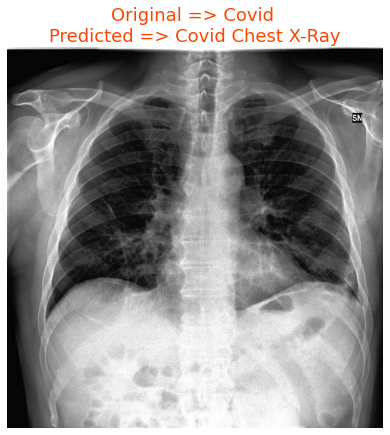

Covid Affected Chest X-Ray Image


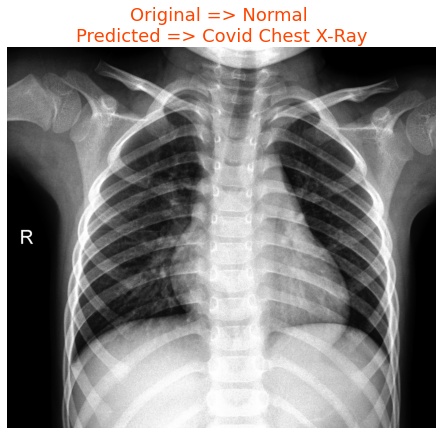

Covid Affected Chest X-Ray Image


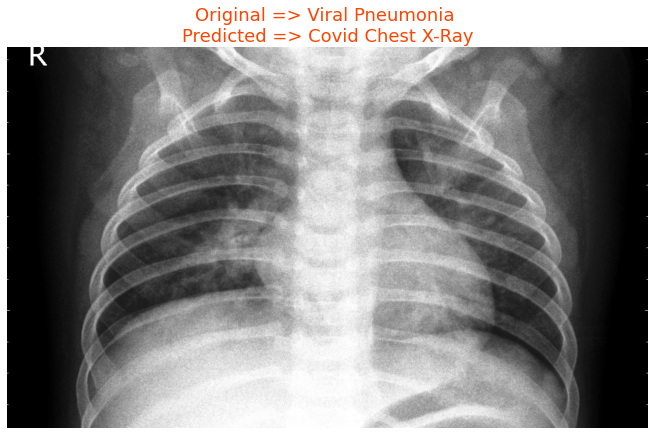

In [29]:
def chest_prediction(pres,dr):
    im = mpimg.imread(pres)     # reading images
    img = image.load_img(pres,target_size=(img_h,img_w))      # reading images
    img = image.img_to_array(img)     # converting present image to array
    img = np.expand_dims(img,axis=0)   
    pred=model_sq.predict(img)    # predict images
    pred_1=np.argmax(pred, axis=1)
    if pred_1[0]==0:
        print("Covid Affected Chest X-Ray Image")
        plt.figure(figsize=(14,7))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Covid Chest X-Ray".format(dr),fontsize=18,color="#FF4500")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    elif pred_1[0]==1:
        print("Normal Chest X-Ray Image")
        plt.figure(figsize=(12,6))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Normal X-Ray".format(dr),fontsize=18,color="#046307")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    elif pred_1[0]==2:
        print("Viral Pneumonia Affected Chest X-Ray Image")
        plt.figure(figsize=(12,6))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Viral Pneumonia Chest X-Ray".format(dr),fontsize=18,color="#DC143C")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    
lbldir=os.listdir(test_path)
print(lbldir)
# detecting covid images
pres=os.path.join(test_path,lbldir[0],os.listdir(test_path+"/"+lbldir[0])[0])
chest_prediction(pres,lbldir[0])
#detecting normal image
pres=os.path.join(test_path,lbldir[1],os.listdir(test_path+"/"+lbldir[1])[0])
chest_prediction(pres,lbldir[1])
# detecting pneumonia image
pres=os.path.join(test_path,lbldir[2],os.listdir(test_path+"/"+lbldir[2])[4])
chest_prediction(pres,lbldir[2])

In [30]:
model_sq.save('pneumonia_model_seq.h5')

## VGG Model for CNN

In [31]:
vgg = VGG16(input_shape=[img_h,img_w] + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable=False
folders=glob('D:\Covid19-dataset\train\*')
x=Flatten()(vgg.output)
prediction=Dense(3,activation='softmax')(x)
model_vgg = Model(inputs=vgg.input, outputs=prediction)
model_vgg.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [32]:
history_vgg = model_vgg.fit(
  train_generator,
  batch_size=16,
  validation_data=test_generator,
  epochs=10
)

Epoch 1/10
8/8 [==============================] - 161s 20s/step - loss: 2.7649 - accuracy: 0.3825 - val_loss: 2.0537 - val_accuracy: 0.5152
Epoch 2/10
8/8 [==============================] - 141s 18s/step - loss: 1.0349 - accuracy: 0.6295 - val_loss: 0.7239 - val_accuracy: 0.5758
Epoch 3/10
8/8 [==============================] - 142s 18s/step - loss: 0.7393 - accuracy: 0.7131 - val_loss: 0.5828 - val_accuracy: 0.7273
Epoch 4/10
8/8 [==============================] - 143s 18s/step - loss: 0.4577 - accuracy: 0.8446 - val_loss: 0.2715 - val_accuracy: 0.8788
Epoch 5/10
8/8 [==============================] - 142s 18s/step - loss: 0.4561 - accuracy: 0.8008 - val_loss: 0.3649 - val_accuracy: 0.8182
Epoch 6/10
8/8 [==============================] - 144s 18s/step - loss: 0.3572 - accuracy: 0.8566 - val_loss: 0.5350 - val_accuracy: 0.7727
Epoch 7/10
8/8 [==============================] - 148s 18s/step - loss: 0.3032 - accuracy: 0.8725 - val_loss: 0.2961 - val_accuracy: 0.8485
Epoch 8/10
8/8 [====

In [33]:
train_acc = history_vgg.history['accuracy']
test_acc = history_vgg.history['val_accuracy']
train_loss = history_vgg.history['loss']
test_loss = history_vgg.history['val_loss']
model_stat_vgg=pd.DataFrame({
    "Epoch":[i+1 for i in range(10)],
    "Training Loss":train_loss,
    "Test Loss":test_loss,
    "Training Accuracy":train_acc,
    "Test Accuracy":test_acc
})
model_stat_vgg.to_csv("model_vgg.csv")
model_stat_vgg

,Epoch,Training Loss,Test Loss,Training Accuracy,Test Accuracy
0,1,2.764853,2.053742,0.382470,0.515152
1,2,1.034867,0.723938,0.629482,0.575758
2,3,0.739287,0.582778,0.713147,0.727273
3,4,0.457703,0.271512,0.844622,0.878788
4,5,0.456053,0.364942,0.800797,0.818182
5,6,0.357165,0.535040,0.856574,0.772727
6,7,0.303167,0.296063,0.872510,0.848485
7,8,0.332254,0.211828,0.876494,0.939394
8,9,0.231560,0.259412,0.928287,0.893939
9,10,0.211259,0.211558,0.916335,0.924242


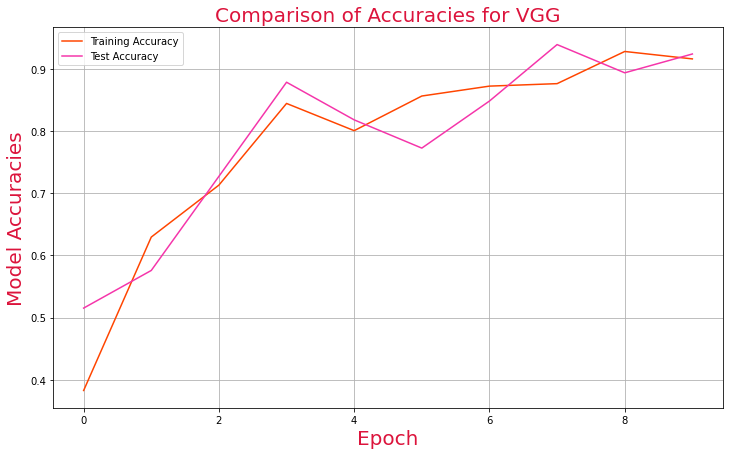

In [34]:
collist=["#FF4500","#F535AA"]
model_stat_vgg.iloc[:,3:].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Accuracies for VGG",fontsize=20,color="#DC143C")
plt.xlabel("Epoch",fontsize=20,color="#DC143C")
plt.ylabel("Model Accuracies",fontsize=20,color="#DC143C")
plt.grid()
plt.show()

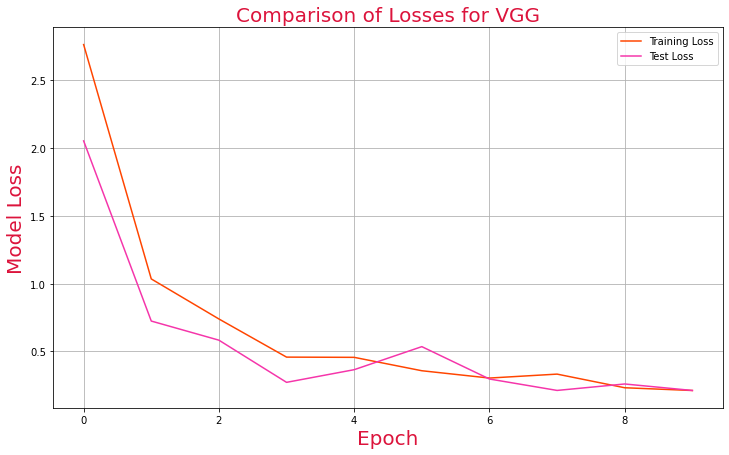

In [35]:
model_stat_vgg.iloc[:,1:3].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Losses for VGG",fontsize=20,color="#DC143C")
plt.xlabel("Epoch",fontsize=20,color="#DC143C")
plt.ylabel("Model Loss",fontsize=20,color="#DC143C")
plt.grid()
plt.show()

In [36]:
y_pred = model_vgg.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.classes
vgg_out=pd.DataFrame({"Actual":class_labels,"Predicted":y_pred})
vgg_out["Actual"]=vgg_out["Actual"].replace(vgg_out["Actual"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
vgg_out["Predicted"]=vgg_out["Predicted"].replace(vgg_out["Predicted"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
prec.append(round(precision_score(vgg_out["Actual"], vgg_out["Predicted"], average='micro'),2)*100)     # Precision of the model
rcl.append(round(recall_score(vgg_out["Actual"], vgg_out["Predicted"], average='micro'),2)*100)     # Recall of the model
f1.append(round(f1_score(vgg_out["Actual"], vgg_out["Predicted"], average='micro'),2)*100)     # F1-Score of the model
acc.append(round(model_stat_vgg['Training Accuracy'].max(),4)*100)
print("Accuracy for VGG16 Model => {}".format(round(model_stat_vgg['Training Accuracy'].max(),4)*100))
ct_vgg=pd.crosstab(vgg_out["Actual"], vgg_out["Predicted"], rownames=['True'], colnames=['Predicted'], margins=True)
ct_vgg.iloc[:3,:3]

Accuracy for VGG16 Model => 92.83


Predicted,Covid,Normal,Viral Pneumonia
True,,,
Covid,52,29,30
Normal,30,18,22
Viral Pneumonia,34,15,21


['Covid', 'Normal', 'Viral Pneumonia']
Covid Affected Chest X-Ray Image


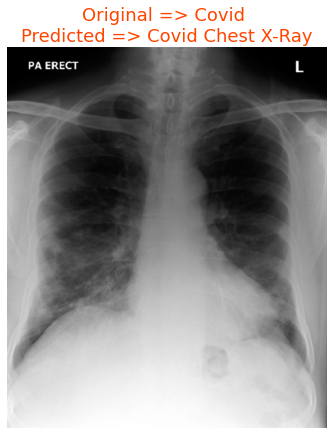

Normal Chest X-Ray Image


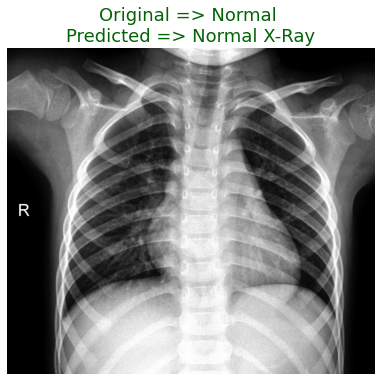

Normal Chest X-Ray Image


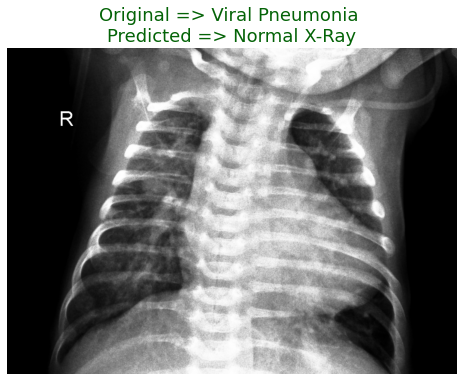

In [37]:
def chest_prediction(pres,dr):
    im = mpimg.imread(pres)
    img = image.load_img(pres,target_size=(img_h,img_w))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    pred=model_vgg.predict(img)
    pred_1=np.argmax(pred, axis=1)
    if pred_1[0]==0:
        print("Covid Affected Chest X-Ray Image")
        plt.figure(figsize=(14,7))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Covid Chest X-Ray".format(dr),fontsize=18,color="#FF4500")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    elif pred_1[0]==1:
        print("Normal Chest X-Ray Image")
        plt.figure(figsize=(12,6))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Normal X-Ray".format(dr),fontsize=18,color="#046307")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    elif pred_1[0]==2:
        print("Viral Pneumonia Affected Chest X-Ray Image")
        plt.figure(figsize=(12,6))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Viral Pneumonia Chest X-Ray".format(dr),fontsize=18,color="#DC143C")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    
lbldir=os.listdir(test_path)
print(lbldir)
pres=os.path.join(test_path,lbldir[0],os.listdir(test_path+"/"+lbldir[0])[1])
chest_prediction(pres,lbldir[0])
pres=os.path.join(test_path,lbldir[1],os.listdir(test_path+"/"+lbldir[1])[0])
chest_prediction(pres,lbldir[1])
pres=os.path.join(test_path,lbldir[2],os.listdir(test_path+"/"+lbldir[2])[2])
chest_prediction(pres,lbldir[2])

In [38]:
model_vgg.save('pneumonia_model_vgg.h5')

## DenseNet121 Model for CNN

In [39]:
trainset=[]
mapping={ 'Normal':0,'Viral Pneumonia':1,'Covid':2 }

In [40]:
den121 = tf.keras.applications.DenseNet121(input_shape=(img_h,img_w,3),include_top=False,weights='imagenet',pooling='avg')
den121.trainable = False

inputs_den =den121.input
x_den = tf.keras.layers.Dense(128, activation='relu')(den121.output)
outputs_den = tf.keras.layers.Dense(3, activation='softmax')(x_den)
model_den = tf.keras.Model(inputs=inputs_den, outputs=outputs_den)

model_den.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history_den = model_den.fit(
  train_generator,
  batch_size=16,
  validation_data=test_generator,
  epochs=10
)

Epoch 1/10
8/8 [==============================] - 79s 9s/step - loss: 0.9182 - accuracy: 0.5538 - val_loss: 0.7222 - val_accuracy: 0.6818
Epoch 2/10
8/8 [==============================] - 69s 9s/step - loss: 0.4886 - accuracy: 0.8167 - val_loss: 0.5797 - val_accuracy: 0.6818
Epoch 3/10
8/8 [==============================] - 69s 9s/step - loss: 0.3650 - accuracy: 0.8406 - val_loss: 0.4636 - val_accuracy: 0.8030
Epoch 4/10
8/8 [==============================] - 70s 9s/step - loss: 0.3433 - accuracy: 0.8765 - val_loss: 0.4337 - val_accuracy: 0.8030
Epoch 5/10
8/8 [==============================] - 68s 8s/step - loss: 0.2933 - accuracy: 0.8805 - val_loss: 0.3923 - val_accuracy: 0.8030
Epoch 6/10
8/8 [==============================] - 70s 9s/step - loss: 0.2359 - accuracy: 0.9084 - val_loss: 0.4014 - val_accuracy: 0.8485
Epoch 7/10
8/8 [==============================] - 67s 8s/step - loss: 0.2305 - accuracy: 0.9163 - val_loss: 0.3192 - val_accuracy: 0.8788
Epoch 8/10
8/8 [==================

In [41]:
model_den.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 306, 306, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

dense_5 (Dense)                 (None, 128)          131200      avg_pool[0][0]                   
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 3)            387         dense_5[0][0]                    
Total params: 7,169,091
Trainable params: 131,587
Non-trainable params: 7,037,504
__________________________________________________________________________________________________


In [42]:
train_acc = history_den.history['accuracy']
test_acc = history_den.history['val_accuracy']
train_loss = history_den.history['loss']
test_loss = history_den.history['val_loss']
model_stat_den=pd.DataFrame({
    "Epoch":[i+1 for i in range(10)],
    "Training Loss":train_loss,
    "Test Loss":test_loss,
    "Training Accuracy":train_acc,
    "Test Accuracy":test_acc
})
model_stat_den.to_csv("model_vgg.csv")
model_stat_den

,Epoch,Training Loss,Test Loss,Training Accuracy,Test Accuracy
0,1,0.918190,0.722248,0.553785,0.681818
1,2,0.488640,0.579741,0.816733,0.681818
2,3,0.365029,0.463638,0.840637,0.803030
3,4,0.343284,0.433749,0.876494,0.803030
4,5,0.293297,0.392250,0.880478,0.803030
5,6,0.235856,0.401432,0.908367,0.848485
6,7,0.230544,0.319165,0.916335,0.878788
7,8,0.206877,0.389229,0.940239,0.848485
8,9,0.191321,0.380656,0.924303,0.787879
9,10,0.164397,0.333452,0.956175,0.818182


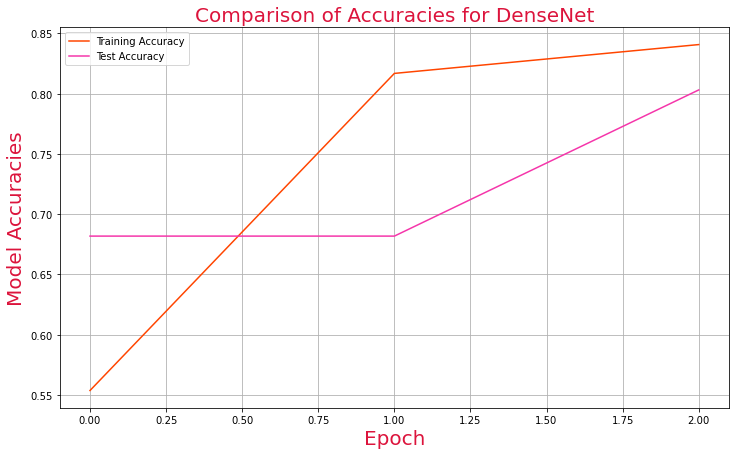

In [43]:
collist=["#FF4500","#F535AA"]
model_stat_den.iloc[:3,3:].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Accuracies for DenseNet",fontsize=20,color="#DC143C")
plt.xlabel("Epoch",fontsize=20,color="#DC143C")
plt.ylabel("Model Accuracies",fontsize=20,color="#DC143C")
plt.grid()
plt.show()

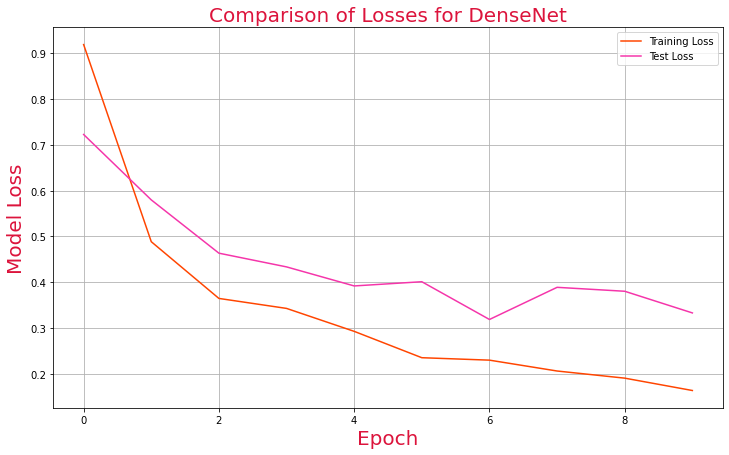

In [44]:
model_stat_den.iloc[:,1:3].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Losses for DenseNet",fontsize=20,color="#DC143C")
plt.xlabel("Epoch",fontsize=20,color="#DC143C")
plt.ylabel("Model Loss",fontsize=20,color="#DC143C")
plt.grid()
plt.show()

In [45]:
y_pred = model_den.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.classes
den_out=pd.DataFrame({"Actual":class_labels,"Predicted":y_pred})
den_out["Actual"]=den_out["Actual"].replace(den_out["Actual"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
den_out["Predicted"]=den_out["Predicted"].replace(den_out["Predicted"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
prec.append(round(precision_score(den_out["Actual"], den_out["Predicted"], average='micro'),2)*100)     # Precision of the model
rcl.append(round(recall_score(den_out["Actual"], den_out["Predicted"], average='micro'),2)*100)     # Recall of the model
f1.append(round(f1_score(den_out["Actual"], den_out["Predicted"], average='micro'),2)*100)     # F1-Score of the model
acc.append(round(model_stat_den['Training Accuracy'].max(),4)*100)
print("Accuracy for DenseNet121 Model => {}".format(round(model_stat_den['Training Accuracy'].max(),4)*100))
ct_den=pd.crosstab(den_out["Actual"], den_out["Predicted"], rownames=['True'], colnames=['Predicted'], margins=True)
ct_den.iloc[:3,:3]

Accuracy for DenseNet121 Model => 95.62


Predicted,Covid,Normal,Viral Pneumonia
True,,,
Covid,36,27,48
Normal,20,11,39
Viral Pneumonia,22,24,24


['Covid', 'Normal', 'Viral Pneumonia']
Covid Affected Chest X-Ray Image


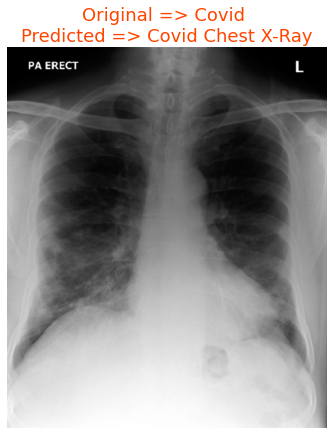

Normal Chest X-Ray Image


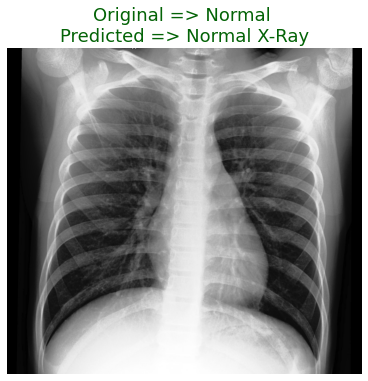

Covid Affected Chest X-Ray Image


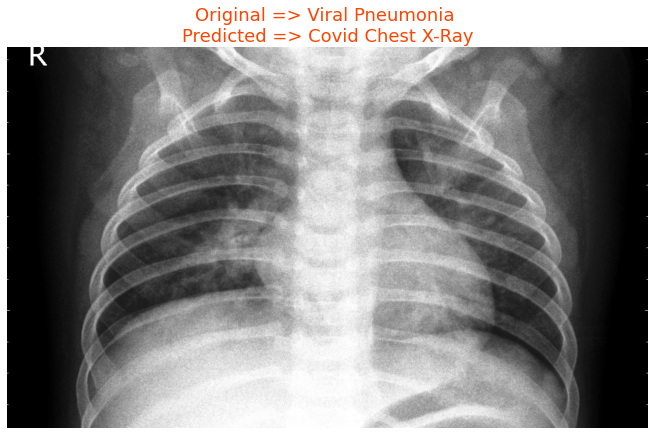

In [46]:
def chest_prediction(pres,dr):
    im = mpimg.imread(pres)
    img = image.load_img(pres,target_size=(img_h,img_w))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    pred=model_den.predict(img)
    pred_1=np.argmax(pred, axis=1)
    if pred_1[0]==0:
        print("Covid Affected Chest X-Ray Image")
        plt.figure(figsize=(14,7))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Covid Chest X-Ray".format(dr),fontsize=18,color="#FF4500")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    elif pred_1[0]==1:
        print("Normal Chest X-Ray Image")
        plt.figure(figsize=(12,6))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Normal X-Ray".format(dr),fontsize=18,color="#046307")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    elif pred_1[0]==2:
        print("Viral Pneumonia Affected Chest X-Ray Image")
        plt.figure(figsize=(12,6))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Viral Pneumonia Chest X-Ray".format(dr),fontsize=18,color="#DC143C")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    
lbldir=os.listdir(test_path)
print(lbldir)
pres=os.path.join(test_path,lbldir[0],os.listdir(test_path+"/"+lbldir[0])[1])
chest_prediction(pres,lbldir[0])
pres=os.path.join(test_path,lbldir[1],os.listdir(test_path+"/"+lbldir[1])[4])
chest_prediction(pres,lbldir[1])
pres=os.path.join(test_path,lbldir[2],os.listdir(test_path+"/"+lbldir[2])[4])
chest_prediction(pres,lbldir[2])

In [47]:
print("===========================================================")
print("===================== Training Accuracy ===================")
print("===========================================================")
print("Training Accuracy of CNN-2D: ",round(model_stat_sq['Training Accuracy'].max(),4)*100,"%")
print("Training Accuracy of VGG16: ",round(model_stat_vgg['Training Accuracy'].max(),4)*100,"%")
print("Training Accuracy of DenseNet121: ",round(model_stat_den['Training Accuracy'].max(),4)*100,"%")
print("===========================================================")
print("====================== Test Accuracy ======================")
print("===========================================================")
print("Test Accuracy of CNN-2D: ",round(model_stat_sq['Test Accuracy'].max(),4)*100,"%")
print("Test Accuracy of VGG16: ",round(model_stat_vgg['Test Accuracy'].max(),4)*100,"%")
print("Test Accuracy of DenseNet121: ",round(model_stat_den['Test Accuracy'].max(),4)*100,"%")
print("===========================================================")
print("====================== Training Loss ======================")
print("===========================================================")
print("Training Loss of CNN-2D: ",round(model_stat_sq['Training Loss'].min(),4)*100,"%")
print("Training Loss of VGG16: ",round(model_stat_vgg['Training Loss'].min(),4)*100,"%")
print("Training Loss of DenseNet121: ",round(model_stat_den['Training Loss'].min(),4)*100,"%")
print("===========================================================")
print("======================== Test Loss ========================")
print("===========================================================")
print("Test Loss of CNN-2D: ",round(model_stat_sq['Test Loss'].min(),4)*100,"%")
print("Test Loss of VGG16: ",round(model_stat_vgg['Test Loss'].min(),4)*100,"%")
print("Test Loss of DenseNet121: ",round(model_stat_den['Test Loss'].min(),4)*100,"%")
print("===========================================================")

===================== Training Accuracy ===================
Training Accuracy of CNN-2D:  76.49000000000001 %
Training Accuracy of VGG16:  92.83 %
Training Accuracy of DenseNet121:  95.62 %
====================== Test Accuracy ======================
Test Accuracy of CNN-2D:  83.33 %
Test Accuracy of VGG16:  93.94 %
Test Accuracy of DenseNet121:  87.88 %
====================== Training Loss ======================
Training Loss of CNN-2D:  61.88 %
Training Loss of VGG16:  21.13 %
Training Loss of DenseNet121:  16.439999999999998 %
======================== Test Loss ========================
Test Loss of CNN-2D:  54.92 %
Test Loss of VGG16:  21.16 %
Test Loss of DenseNet121:  31.919999999999998 %


In [48]:
model_den.save('pneumonia_model_den.h5')

In [49]:
XRAY_out=pd.DataFrame({
    "Algorithm":["CNN2D","VGG16","DenseNet121"],
    "Accuracy":acc,
    "Precision":prec,
    "Recall":rcl,
    "F1-Score":f1,    
})

for i in XRAY_out.columns.tolist()[1:]:
    XRAY_out=XRAY_out.sort_values(by=i,ascending=False)
    fig = px.bar(XRAY_out, y=i, x="Algorithm",color=i,title="Comparison of {}".format(i))
    fig.update_layout(font=dict(family="Times New Roman, Bold",size=15,color="black"))
    fig.show()